In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# !sudo update-alternatives --config python3
# do not select 3.9

In [3]:
!python --version

Python 3.7.15


In [4]:
# !python --version
# #install python 3.9
# !sudo apt-get update -y
# !sudo apt-get install python3.9

# #change alternatives
# !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.7 1
# !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 2

# #check python version
# !python --version


In [5]:
# import sys
# sys.path.insert(0, '/usr/local/lib/python3.7/dist-packages/')

In [6]:
# %pip install numpy==1.21.0
# %pip install scipy==1.9.0

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import scipy.stats as stats
from sklearn.ensemble import IsolationForest
import scipy
# scipy.__version__

In [8]:
# define settings and result paths
main_path = '/content/drive/MyDrive/NonBDNA/' # location on my drive
results_papth = main_path + '/' + 'methods_results'
datasets = ['experimental', 'simulated']
window_size = [50, 100]
data_path = {data + '_' + str(win_size): main_path + data + '_' + str(win_size) for data in datasets for win_size in window_size}
for k, val in enumerate(data_path):
  print(val, 'data Path: ',data_path[val])

experimental_50 data Path:  /content/drive/MyDrive/NonBDNA/experimental_50
experimental_100 data Path:  /content/drive/MyDrive/NonBDNA/experimental_100
simulated_50 data Path:  /content/drive/MyDrive/NonBDNA/simulated_50
simulated_100 data Path:  /content/drive/MyDrive/NonBDNA/simulated_100


In [9]:
# preprocessing and loading the data functions:

def compute_stats(forward, reverse, std_type='median/iqr'):
    if std_type == 'mean/std':
        print('Using mean/std\n')
        tfd_mu, tfd_std = forward.mean(), reverse.std()
        trd_mu, trd_std = forward.mean(), reverse.std()
        return (tfd_mu, tfd_std, trd_mu, trd_std)
    elif std_type == 'median/iqr':
        print('Using median/iqr\n')
        iqr_fd = np.subtract(*np.percentile(forward, [75, 25], interpolation='midpoint'))
        iqr_rd = np.subtract(*np.percentile(reverse, [75, 25], interpolation='midpoint'))
        tfd_mu, tfd_std = np.median(forward), iqr_fd
        trd_mu, trd_std = np.median(reverse), iqr_rd
        return (tfd_mu, tfd_std, trd_mu, trd_std)
    else:
        print('Not implemented\n')


def reprocess_data(bdna_path,percent=0.3, std_type= 'median/iqr', seed=42):
    train_forward = np.load(bdna_path + '/' + 'forward_train_100.npy')
    win_size = train_forward.shape[1]
    train_reverse = np.load(bdna_path + '/' + 'reverse_train_100.npy')
    val_forward = np.load(bdna_path + '/' + 'forward_val_100.npy')
    val_reverse = np.load(bdna_path + '/' + 'reverse_val_100.npy')
    test_forward = np.load(bdna_path + '/' + 'forward_test_100.npy')
    test_reverse = np.load(bdna_path + '/' + 'reverse_test_100.npy')
    forward = np.vstack((train_forward, val_forward, test_forward))
    reverse = np.vstack((train_reverse, val_reverse, test_reverse))
    full_bdna = np.hstack((forward, reverse))
    full_bdna_df = pd.DataFrame(full_bdna)
    full_bdna_df = full_bdna_df.sample(frac=1, random_state=seed)
    train_size = int(percent*len(full_bdna_df))
    full_train0, full_val0 = np.array(full_bdna_df[:train_size]), full_bdna_df[train_size:]
    val_size = int(percent*len(full_val0))
    full_val0, full_test0 = np.array(full_val0[:val_size]), np.array(full_val0[val_size:])
    train_forward = full_train0[:, :win_size]
    train_reverse = full_train0[:, win_size:]
    val_forward = full_val0[:, :win_size]
    val_reverse = full_val0[:, win_size:]
    test_forward = full_test0[:, :win_size]
    test_reverse = full_test0[:, win_size:]
    tfd_mu, tfd_std, trd_mu, trd_std = compute_stats(train_forward,train_reverse, std_type=std_type)
    train_forward = (train_forward - tfd_mu)/tfd_std
    train_reverse = (train_reverse - trd_mu)/trd_std
    val_forward = (val_forward - tfd_mu)/tfd_std
    val_reverse = (val_reverse - trd_mu)/trd_std
    test_forward = (test_forward - tfd_mu)/tfd_std
    test_reverse = (test_reverse - trd_mu)/trd_std
    print('New Train Set {:.2f}'.format(len(full_train0)/len(full_bdna)))
    print('New Validation Set {:.2f}'.format(len(full_val0)/len(full_bdna)))
    print('New Test Set {:.2f}'.format(len(full_test0)/len(full_bdna)))
    return train_forward, train_reverse, val_forward, val_reverse, test_forward, test_reverse, tfd_mu, tfd_std, trd_mu, trd_std



def prepare_nonb_dataset_center(path):
    non_b_types = ['A_Phased_Repeat', 'G_Quadruplex_Motif', 'Inverted_Repeat', 'Mirror_Repeat', 'Direct_Repeat',
                   'Short_Tandem_Repeat', 'Z_DNA_Motif']
    nonb_path_train = {nonb: path + '/' + nonb + '_centered_train.csv' for nonb in non_b_types}
    nonb_path_validation = {nonb: path + '/' + nonb + '_centered_validation.csv' for nonb in non_b_types}
    nonb_path_test = {nonb: path + '/' + nonb + '_centered_test.csv' for nonb in non_b_types}
    nonb_train_dfs = {nonb: pd.read_csv(nonb_path_train[nonb], index_col=0) for nonb in non_b_types}
    nonb_val_dfs = {nonb: pd.read_csv(nonb_path_validation[nonb], index_col=0) for nonb in non_b_types}
    nonb_test_dfs = {nonb: pd.read_csv(nonb_path_test[nonb], index_col=0) for nonb in non_b_types}
    return nonb_train_dfs, nonb_val_dfs, nonb_test_dfs

def load_data(bdna_folder, nonb_folder):
    forward_tr, reverse_tr, forward_val, reverse_val, forward_te, reverse_te, \
    train_forward_mu, train_forward_std, train_reverse_mu, train_reverse_std = reprocess_data(bdna_folder)
    win_size = forward_tr.shape[1]
    # bdna data:
    forward_cols = ['forward_'+str(i) for i in range(win_size)]
    reverse_cols = ['reverse_'+str(i) for i in range(win_size)]
    cols = forward_cols + reverse_cols + ['label']
    tr = np. concatenate((forward_tr, reverse_tr, np.zeros(forward_tr.shape[0]).reshape(-1, 1)), axis=1)
    val = np. concatenate((forward_val, reverse_val, np.zeros(forward_val.shape[0]).reshape(-1, 1)), axis=1)
    te = np. concatenate((forward_te, reverse_te, np.zeros(forward_te.shape[0]).reshape(-1, 1)), axis=1)
    ####################################################
    tr_df_bdna = pd.DataFrame(data=tr, columns=cols, index=range(tr.shape[0]))
    val_df_bdna = pd.DataFrame(data=val, columns=cols, index=range(val.shape[0]))
    te_df_bdna = pd.DataFrame(data=te, columns=cols, index=range(te.shape[0]))
    convert_dict = {'label': int}
    tr_df_bdna = tr_df_bdna.astype(convert_dict)
    val_df_bdna = val_df_bdna.astype(convert_dict)
    te_df_bdna = te_df_bdna.astype(convert_dict)
    tr_df_bdna['label'] = 'bdna'
    val_df_bdna['label'] = 'bdna'
    te_df_bdna['label'] = 'bdna'
    #######################################################################
    # nonb data:
    nonb_tr_dfs, nonb_val_dfs, nonb_te_dfs = prepare_nonb_dataset_center(path=nonb_folder)
    nonb_types = list(nonb_tr_dfs.keys())
    nonb_tr_df = pd.DataFrame(columns=cols)
    nonb_val_df = pd.DataFrame(columns=cols)
    nonb_te_df = pd.DataFrame(columns=cols)
    for non_b in nonb_types:
        sample_df = nonb_tr_dfs[non_b]
        win_size = (len(list(sample_df.columns.values)) - 7) // 3
        nonb_train_forward = nonb_tr_dfs[non_b].iloc[:, 7: win_size + 7].to_numpy()
        nonb_train_reverse = nonb_tr_dfs[non_b].iloc[:, win_size + 7: (2 * win_size) + 7].to_numpy()
        nonb_train_forward = (nonb_train_forward - train_forward_mu)/train_forward_std
        nonb_train_reverse = (nonb_train_reverse - train_reverse_mu)/train_reverse_std
        nonb_train = np.concatenate((nonb_train_forward, nonb_train_reverse, np.ones(nonb_train_forward.shape[0]).reshape(-1, 1)), axis=1)
        this_tr_df_nonb = pd.DataFrame(data=nonb_train, columns=cols, index=range(nonb_train.shape[0]))
        this_tr_df_nonb['label'] = non_b
        nonb_tr_df = nonb_tr_df.append(this_tr_df_nonb).reset_index(drop=True)
        nonb_val_forward = nonb_val_dfs[non_b].iloc[:, 7: win_size + 7].to_numpy()
        nonb_val_reverse = nonb_val_dfs[non_b].iloc[:,  win_size + 7 : (2 * win_size) + 7].to_numpy()
        nonb_val_forward = (nonb_val_forward - train_forward_mu)/train_forward_std
        nonb_val_reverse = (nonb_val_reverse - train_reverse_mu)/train_reverse_std
        nonb_val = np.concatenate((nonb_val_forward, nonb_val_reverse, np.ones(nonb_val_forward.shape[0]).reshape(-1, 1)), axis=1)
        this_val_df_nonb = pd.DataFrame(data=nonb_val, columns=cols, index=range(nonb_val.shape[0]))
        this_val_df_nonb['label'] = non_b
        nonb_val_df = nonb_val_df.append(this_val_df_nonb).reset_index(drop=True)
        nonb_test_forward = nonb_te_dfs[non_b].iloc[:, 7: win_size + 7].to_numpy()
        nonb_test_reverse = nonb_te_dfs[non_b].iloc[:, win_size + 7:(2 * win_size) + 7].to_numpy()
        nonb_test_forward = (nonb_test_forward - train_forward_mu)/train_forward_std
        nonb_test_reverse = (nonb_test_reverse - train_reverse_mu)/train_reverse_std
        nonb_test = np.concatenate((nonb_test_forward, nonb_test_reverse, np.ones(nonb_test_forward.shape[0]).reshape(-1, 1)), axis=1)
        this_test_df_nonb = pd.DataFrame(data=nonb_test, columns=cols, index=range(nonb_test.shape[0]))
        this_test_df_nonb['label'] = non_b
        nonb_te_df = nonb_te_df.append(this_test_df_nonb).reset_index(drop=True)
    # nonb_tr_df = nonb_tr_df.astype(convert_dict)
    # nonb_val_df = nonb_val_df.astype(convert_dict)
    # nonb_te_df = nonb_te_df.astype(convert_dict)
    train = tr_df_bdna.append(nonb_tr_df).sample(frac=1, random_state=42).reset_index(drop=True)
    val = val_df_bdna.append(nonb_val_df).sample(frac=1, random_state=42).reset_index(drop=True)
    test = te_df_bdna.append(nonb_te_df).sample(frac=1, random_state=42).reset_index(drop=True)
    return train, val, test


In [10]:
# evaluation functions:

def compute_empirical(null_dist, eval_data, tail='two_sided'):
    store_emp_pval = []
    if tail == 'lower':
        for i in range(len(eval_data)):
            temp = stats.percentileofscore(null_dist, eval_data[i])/100.
            store_emp_pval.append(temp)
    elif tail == 'upper':
        for i in range(len(eval_data)):
            temp = 1. - stats.percentileofscore(null_dist, eval_data[i])/100.
            store_emp_pval.append(temp)
    else:
        print('Not defined')
    emp_dist = np.sort(np.array(store_emp_pval))
    indices = np.argsort(np.array(store_emp_pval))
    return emp_dist, indices


def FDR_BHP(dist,alpha=0.5):
    BH_corrected = alpha * np.arange(1,len(dist)+1)/len(dist)
    check = (dist <= BH_corrected)
    if check.sum() != 0:
        valemp = np.max(np.argwhere(check))+1
        FDR = valemp*(1. - alpha)/len(dist)
    else:
        valemp = 0
        FDR = 0
    return valemp, FDR

def compute_accuracy_metrics(tn, fp, fn, tp):
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    fscore = (2 * precision * recall) / (precision + recall)
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    fdr = fp / (fp + tp) # False discovery rate
    return accuracy, precision, recall, fscore, fpr, fnr, fdr

In [11]:
def plot_histograms(null_dist_scores, eval_scores, title1, title2):
    fig, axes = plt.subplots(1, 2)
    n, bins, patches = axes[0].hist(null_dist_scores, 50)
    n, bins, patches = axes[1].hist(eval_scores, 50)
    axes[0].set_title(title1)
    axes[1].set_title(title2)
    plt.tight_layout()
    plt.show()

def plot_results(final_results_df, nonb, method):
    upper_df = final_results_df[final_results_df['tail']=='upper'].reset_index(drop = True)
    lower_df = final_results_df[final_results_df['tail']=='lower'].reset_index(drop = True)
    tail_types = ['upper', 'lower']


    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    for t, tail_type in enumerate(tail_types):
        this_df = final_results_df[final_results_df['tail']==tail_type].reset_index(drop = True)
        tuples = list(zip(this_df.alpha, this_df.potential_nonb_counts))
        fdrs = [i[0] for i in tuples]
        values = [i[1] for i in tuples]
        axes[t].plot(fdrs, values, color='tab:blue', linewidth=3, marker='o', label=method)     
        axes[t].set_xlabel('FDR', fontsize=27)
        axes[t].set_ylabel('Non-B DNA Count', fontsize=27)

        plt.setp(axes[t].get_xticklabels(), Fontsize=22)
        plt.setp(axes[t].get_yticklabels(), Fontsize=22)

        axes[t].set_title(nonb + ', '+ tail_type, fontsize=20)
        axes[t].legend()
        plt.tight_layout()
    plt.show()

In [12]:
def cross_validation(train_x, train_y, val_x, val_y):
  param_vector = [1, 2, 3]
  best_param = param_vector[0]
  # save the results if possible
  # results.to_csv(os.path.join(save_path, method + '_cv.csv'))
  return best_param

In [13]:
def pipeline(global_train, global_val, global_test, nonb):
    print('Making model for', nonb, '...')
    final_results_df = pd.DataFrame(columns=['method', 'label', 'alpha', 'tail', 'potential_nonb_counts'], index=range(19*2))
    counter = 0 

    train = global_train[(global_train['label'] == nonb)|(global_train['label'] == 'bdna')].reset_index(drop=True)
    val = global_val[(global_val['label'] == nonb)|(global_val['label'] == 'bdna')].reset_index(drop=True)
    test = global_test[(global_test['label'] == nonb)|(global_test['label'] == 'bdna')].reset_index(drop=True)

    train.loc[train['label'] == 'bdna', 'label'] = 0
    train.loc[train['label'] == nonb, 'label'] = 1

    val.loc[val['label'] == 'bdna', 'label'] = 0
    val.loc[val['label'] == nonb, 'label'] = 1

    test.loc[test['label'] == 'bdna', 'label'] = 0
    test.loc[test['label'] == nonb, 'label'] = 1

    convert_dict = {'label': int}

    train = train.astype(convert_dict)
    val = val.astype(convert_dict)
    test = test.astype(convert_dict)

    train_x = train.drop(['label'], axis=1).to_numpy()
    train_y = train[['label']].to_numpy()

    val_x = val.drop(['label'], axis=1).to_numpy()
    val_y = val[['label']].to_numpy()

    test_x = test.drop(['label'], axis=1).to_numpy()
    test_y = test[['label']].to_numpy()

    # Apply cross validation on train and validation dataset if needed:
    # best_param = cross_validation(train_x, train_y, val_x, val_y)


    # train with new train which is (train + val) and the best param (or any parameter of choice)
    train = train.append(val).reset_index(drop=True)
    train_x = train.drop(['label'], axis=1).to_numpy()

    # use the best parameter if any found in cross validation step
    isolation_forest_model = IsolationForest().fit(train_x)

    # test only using the test set:
    test_bdna = test[test['label'] == 0].reset_index(drop=True)
    test_bdna_x = test_bdna.drop(['label'], axis=1).to_numpy()
    # test_bdna_y = test_bdna[['label']].to_numpy()

    test_nonb = test[test['label'] == 1].reset_index(drop=True)
    test_nonb_x = test_nonb.drop(['label'], axis=1).to_numpy()

    null_dist_scores = isolation_forest_model.decision_function(test_bdna_x)
    eval_scores = isolation_forest_model.decision_function(test_nonb_x)
    plot_histograms(null_dist_scores, eval_scores, nonb + ' - Null Distribution', nonb + ' - Normality Scores')

    # define the FDR rate
    alpha_list = np.arange(0.05, 1, 0.05)
    emp_dist_upper, _ = compute_empirical(null_dist_scores, eval_scores, tail='upper')

    for alpha in alpha_list:
        val_emp, _ = FDR_BHP(emp_dist_upper, alpha=alpha)
        final_results_df.loc[counter, :] = method, nonb, alpha, 'upper', val_emp
        counter += 1
        
    emp_dist_lower, _ = compute_empirical(null_dist_scores, eval_scores, tail='lower')

    for alpha in alpha_list:
        val_emp, _ = FDR_BHP(emp_dist_lower, alpha=alpha)
        final_results_df.loc[counter, :] = method, nonb, alpha, 'lower', val_emp
        counter += 1

    plot_histograms(emp_dist_upper, emp_dist_lower, nonb +' P-value Upper', nonb + ' P-value Lower')
    final_results_df.to_csv(os.path.join(save_path, method + '_' + nonb + '_final_results.csv'))
    final_results_df = final_results_df.dropna()

    plot_results(final_results_df, nonb, method)


Using median/iqr

New Train Set 0.30
New Validation Set 0.21
New Test Set 0.49
Making model for Z_DNA_Motif ...


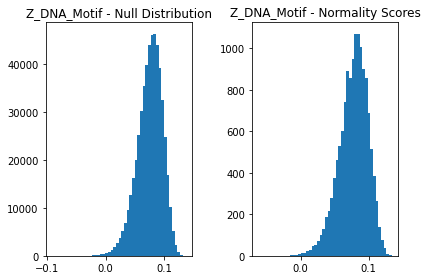

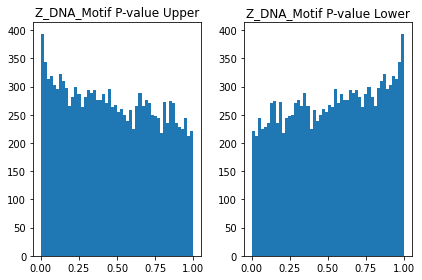

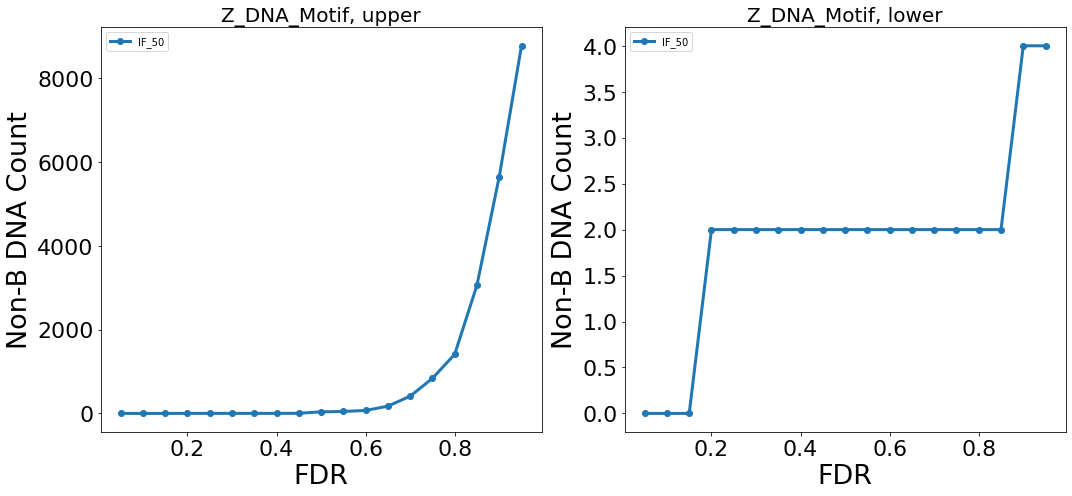

In [14]:
# methods pipeline:
# loading data and preprocessing: 
dataset_name = 'experimental_50'
method = 'IF_50'

non_b_types = ['A_Phased_Repeat', 'G_Quadruplex_Motif', 'Inverted_Repeat', 'Mirror_Repeat', 'Direct_Repeat', 'Short_Tandem_Repeat', 'Z_DNA_Motif']

save_path = results_papth + '/' + method
if not os.path.exists(save_path):
    os.mkdir(save_path)

bdna_path = data_path[dataset_name]
non_b_path = data_path[dataset_name]

measures = ['tn', 'fp', 'fn', 'tp', 'accuracy', 'precision', 'recall', 'f-score', 'fpr', 'fnr', 'fdr']
cv_results = pd.DataFrame(columns=measures + ['data', 'parameter', 'label'])
# load the data: This function applies preprocessing too:
global_train, global_val, global_test = load_data(bdna_path, non_b_path)


# # Make a model for each nonb type:
# for nonb in non_b_types:
#     pipeline(global_train, global_val, global_test, nonb)

# Example:
pipeline(global_train, global_val, global_test, 'Z_DNA_Motif')